# Ray et al 2013 Plotting 
**Authorship:**
Adam Klie, *09/03/2022*
***
**Description:**
Notebook to generate plots for the Ray et al (2013) dataset that are not included in the other notebooks.
***

In [ ]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [1]:
# General imports
import os
import glob
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import seqdata as sd
import eugene as eu
from scipy.stats import spearmanr, pearsonr

# EUGENe imports and settings
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/ray13"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/ray13"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/ray13"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/ray13"

# For illustrator editing
import matplotlib
import matplotlib.pyplot as plt
settings.dpi = 300
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Matplotlib is building the font cache; this may take a moment.


# Performances from Alipanahi et al
Downloaded and will load in Supllementary Table 3

In [2]:
# Read in the results from the ray13 analysis
sheet_name = ["Pearson of E-scores",
              "Spearman of E-scores",
              "Pearson of AUCs",
              "Spearman of AUCs",
              "Pearson of Z-scores",
              "Spearman of Z-scores",
              "Pearson with Intensities",
              "Spearman with intensities"]
performance_df = pd.DataFrame()
for sheet in sheet_name:
    x = pd.read_excel(os.path.join(settings.dataset_dir, "41587_2015_BFnbt3300_MOESM53_ESM.xlsx"), sheet_name=sheet, skiprows=1, index_col=0)
    x["Metric"] = sheet.split(" ")[2]
    x["Correlation"] = sheet.split(" ")[0]
    x["Metric"] = x["Metric"].replace({"intensities": "Intensities"})
    x = x.rename({"Intensities": "Observed intensities", "MatrixREDUE": "MatrixREDUCE"}, axis=1)
    performance_df = pd.concat([performance_df, x], axis=0)
performance_summary = performance_df.melt(id_vars=["Correlation", "Metric"], var_name="Method", value_name="Value")

/tmp/ipykernel_1953333/3645765156.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]


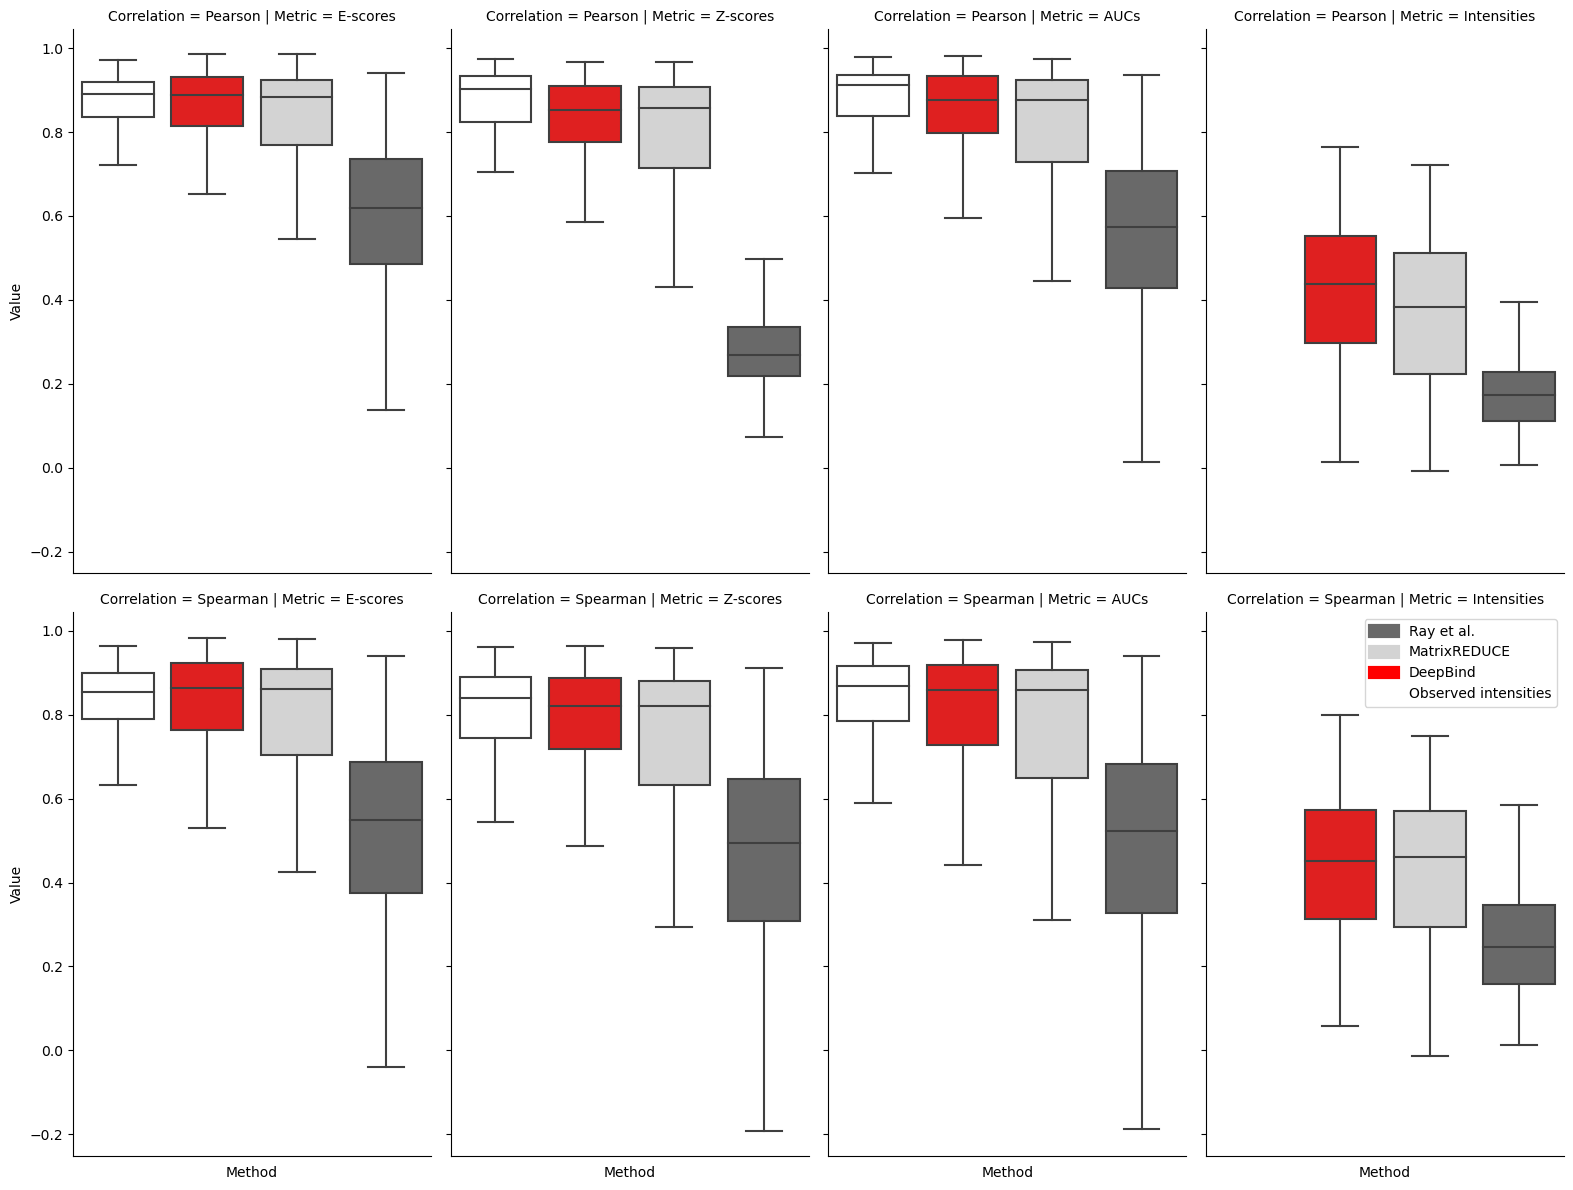

In [3]:
# Plot similar to Supplementary Figure 3 in Alipahani et al
my_pal = {"Ray et al.": "dimgrey", "MatrixREDUCE": "lightgrey", "DeepBind": "red", "Observed intensities": "white"}
order = ["Observed intensities", "DeepBind", "MatrixREDUCE", "Ray et al."]
g = sns.FacetGrid(
    performance_summary, 
    row="Correlation", 
    col="Metric", 
    row_order=["Pearson", "Spearman"], 
    col_order=["E-scores", 
               "Z-scores", 
               "AUCs", 
               "Intensities"],
    height=6,
    aspect=0.66
)
g.map(sns.boxplot, "Method", "Value", palette=my_pal, order=order, showfliers = False)
patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]
plt.legend(handles=patches)
g.set(xticks=[])
g.fig.tight_layout()

# Performances from EUGENe

In [4]:
# Load in the long tables that calculated all 4 metrics for all 244 RBPs (Pearson and Spearman)
n_kmers = None
pearson_long = pd.DataFrame()
spearman_long = pd.DataFrame()
for method in ["setA", "ST", "MT", "kipoi"]:
    print(f"spearman/pearson_performance_{n_kmers}kmers_{method}.tsv")
    x_pearson = pd.read_csv(os.path.join(settings.output_dir, "performance", f"pearson_performance_{n_kmers}kmers_{method}.tsv"), sep="\t")
    pearson_long = pd.concat([pearson_long, x_pearson], axis=0)
    x_spearman = pd.read_csv(os.path.join(settings.output_dir, "performance", f"spearman_performance_{n_kmers}kmers_{method}.tsv"), sep="\t")
    spearman_long = pd.concat([spearman_long, x_spearman], axis=0)

spearman/pearson_performance_Nonekmers_setA.tsv
spearman/pearson_performance_Nonekmers_ST.tsv
spearman/pearson_performance_Nonekmers_MT.tsv
spearman/pearson_performance_Nonekmers_kipoi.tsv


In [5]:
# Convert my performances into the same format as the paper table above
spearman_df = spearman_long.pivot(index=['RBP', 'Metric'], columns='Model', values='Spearman').reset_index()
spearman_df["Correlation"] = "Spearman"
pearson_df = pearson_long.pivot(index=['RBP', 'Metric'], columns='Model', values='Pearson').reset_index()
pearson_df["Correlation"] = "Pearson"
trained_perfromance_df = pd.concat([pearson_df, spearman_df], axis=0)
trained_perfromance_df["Metric"] = trained_perfromance_df["Metric"].replace({"Z-score":"Z-scores", "AUC":"AUCs", "E-score":"E-scores", "Intensity": "Intensities"})
trained_perfromance_df.head()

Model,RBP,Metric,Kipoi,MultiTask,SetA,SingleTask,Correlation
0,RNCMPT00001,AUCs,0.887739,0.854301,0.921486,0.885715,Pearson
1,RNCMPT00001,E-scores,0.864648,0.846280,0.896020,0.881837,Pearson
2,RNCMPT00001,Intensities,0.551630,0.480416,NaN,0.488479,Pearson
3,RNCMPT00001,Z-scores,0.819445,0.839188,0.912864,0.844452,Pearson
4,RNCMPT00002,AUCs,0.745691,0.586616,0.833302,0.458373,Pearson


In [6]:
# Harmonize the paper table
paper_performance_df = performance_df.reset_index().rename({"index": "RBP"}, axis=1)
paper_performance_df.head()

,RBP,Observed intensities,DeepBind,MatrixREDUCE,Ray et al.,Metric,Correlation
0,RNCMPT00001,0.897,0.871,0.892,0.332,E-scores,Pearson
1,RNCMPT00002,0.810,0.761,0.795,0.365,E-scores,Pearson
2,RNCMPT00003,0.908,0.669,0.716,0.741,E-scores,Pearson
3,RNCMPT00004,0.942,0.957,0.959,0.729,E-scores,Pearson
4,RNCMPT00005,0.936,0.940,0.934,0.869,E-scores,Pearson


In [7]:
# Make sure they have the same length
len(paper_performance_df), len(trained_perfromance_df)

(1952, 1952)

In [8]:
# Create the aggregated table
full_performance_df = pd.merge(trained_perfromance_df, paper_performance_df, on=["RBP", "Metric", "Correlation"]).set_index("RBP")
full_performance_summary = full_performance_df.melt(id_vars=["Correlation", "Metric"], var_name="Method", value_name="Value")
full_performance_summary["Method"].value_counts()

Kipoi                   1952
MultiTask               1952
SetA                    1952
SingleTask              1952
Observed intensities    1952
DeepBind                1952
MatrixREDUCE            1952
Ray et al.              1952
Name: Method, dtype: int64

In [9]:
full_performance_df

,Metric,Kipoi,MultiTask,SetA,SingleTask,Correlation,Observed intensities,DeepBind,MatrixREDUCE,Ray et al.
RBP,,,,,,,,,,
RNCMPT00001,AUCs,0.887739,0.854301,0.921486,0.885715,Pearson,0.921,0.879,0.904,0.396
RNCMPT00001,E-scores,0.864648,0.846280,0.896020,0.881837,Pearson,0.897,0.871,0.892,0.332
RNCMPT00001,Intensities,0.551630,0.480416,NaN,0.488479,Pearson,NaN,0.469,0.472,0.259
RNCMPT00001,Z-scores,0.819445,0.839188,0.912864,0.844452,Pearson,0.913,0.859,0.879,0.309
RNCMPT00002,AUCs,0.745691,0.586616,0.833302,0.458373,Pearson,0.830,0.751,0.773,0.342
...,...,...,...,...,...,...,...,...,...,...
RNCMPT00289,Z-scores,NaN,0.806843,0.819211,0.760558,Spearman,0.819,0.831,0.555,0.577
RNCMPT00291,AUCs,NaN,0.763356,0.854829,0.856544,Spearman,0.855,0.865,0.887,0.140
RNCMPT00291,E-scores,NaN,0.773171,0.832572,0.853335,Spearman,0.806,0.857,0.864,0.141


In [10]:
# Save the full table results for supplement
full_performance_df.to_csv(os.path.join(settings.output_dir, "full_performance_df.tsv"), sep="\t", index=True)

# Performance boxplot

/tmp/ipykernel_3846556/3693152122.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]


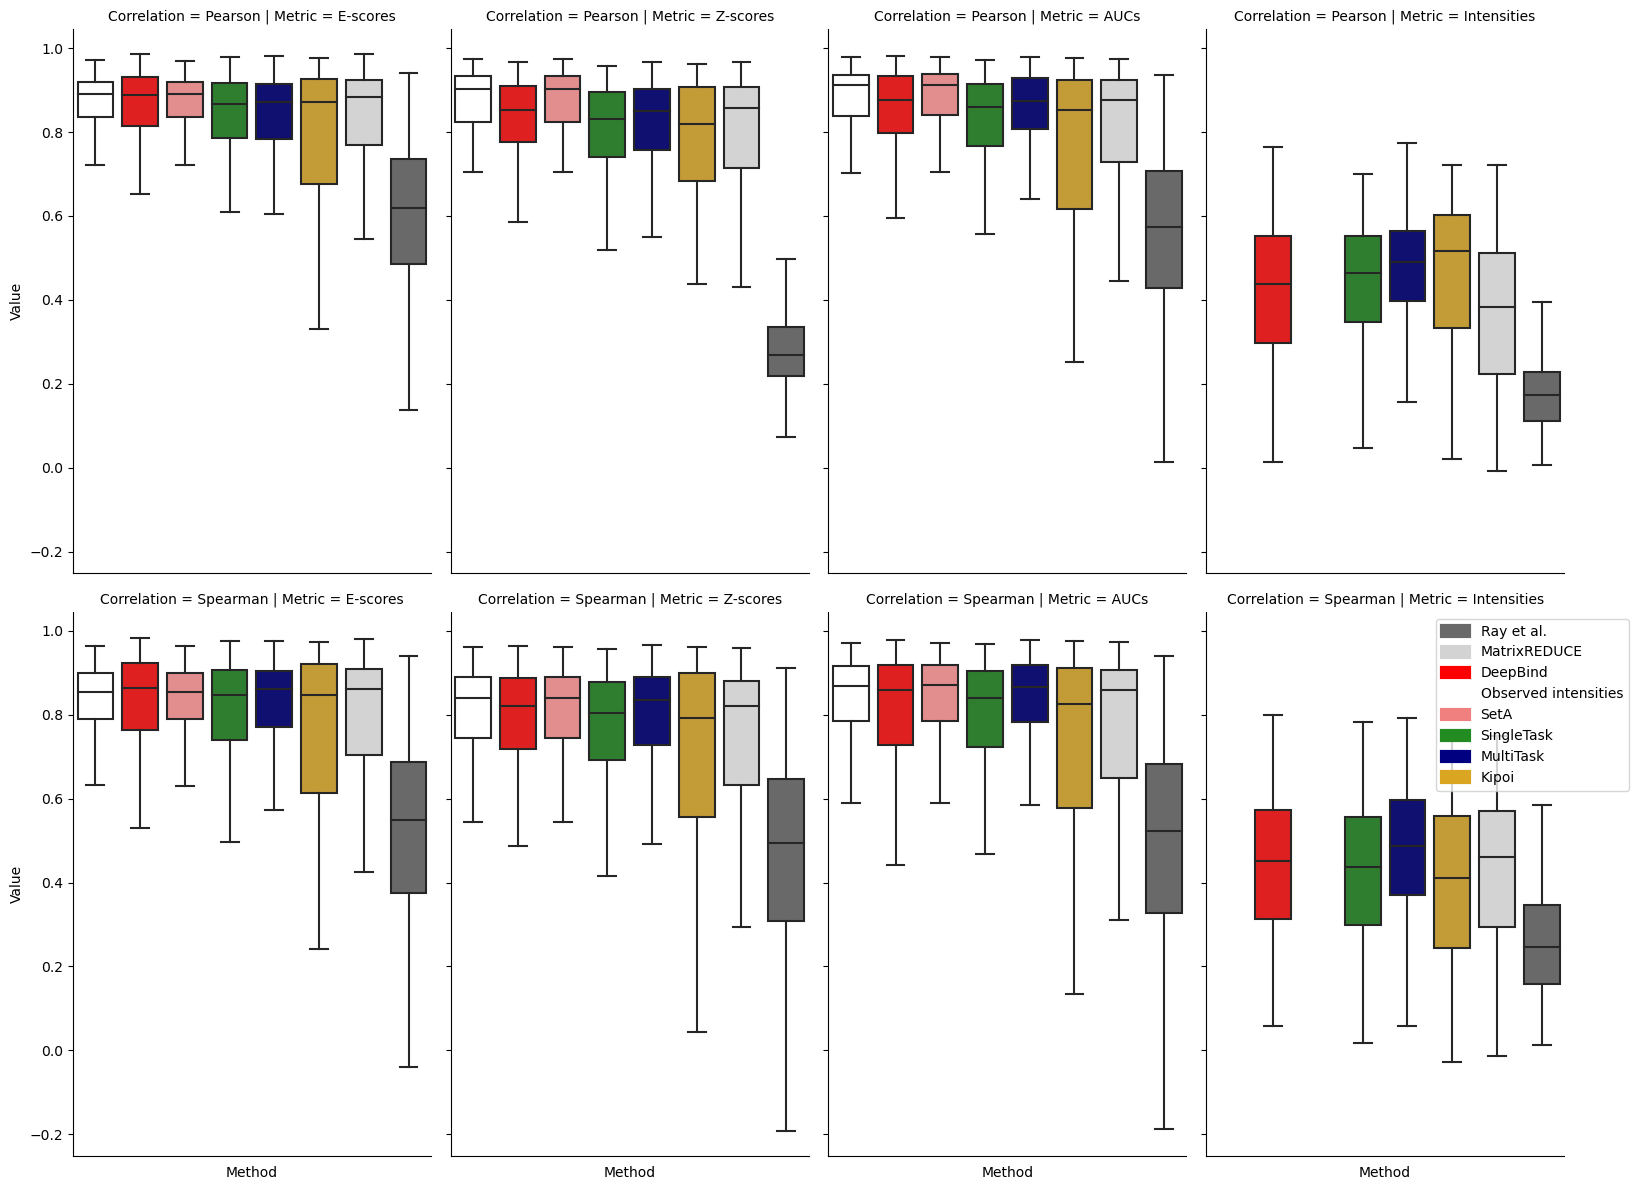

In [11]:
my_pal = {"Ray et al.": "dimgrey", "MatrixREDUCE": "lightgrey", "DeepBind": "red", "Observed intensities": "white",
         "SetA": "lightcoral", "SingleTask": "forestgreen", "MultiTask": "navy", "Kipoi": "goldenrod"}
order = ["Observed intensities", "DeepBind", "SetA", "SingleTask", "MultiTask", "Kipoi", "MatrixREDUCE", "Ray et al."]
g = sns.FacetGrid(
    full_performance_summary, 
    row="Correlation", 
    col="Metric", 
    row_order=["Pearson", "Spearman"], 
    col_order=["E-scores", 
               "Z-scores", 
               "AUCs", 
               "Intensities"],
    height=6,
    aspect=0.66
)
g.map(sns.boxplot, "Method", "Value", palette=my_pal, order=order, showfliers = False)
patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]
g.set(xticks=[])
g.fig.tight_layout()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1))
plt.savefig(os.path.join(settings.figure_dir, f"correlation_boxplots_{n_kmers}kmers_all.pdf"), dpi=300)

# Comparison scatterplots

In [12]:
# Helper function to plot the a line to apply to FacetGrid
def const_line(*args, **kwargs):
    x = np.arange(0, 1.01, 0.01)
    plt.plot(x, x, c='dimgrey', ls='--')

In [13]:
import itertools
order = ["SingleTask", "MultiTask", "SetA", "Kipoi", "Observed intensities", "DeepBind",  "MatrixREDUCE", "Ray et al."]
if not os.path.exists(os.path.join(settings.figure_dir, "scatterplot_comparisons")):
    os.makedirs(os.path.join(settings.figure_dir, "scatterplot_comparisons"))
for method_x, method_y in list(itertools.combinations(order, 2)):
    g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
    g.map(sns.scatterplot, method_x, method_y, s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
    g.map(const_line)
    method_x_save = method_x.replace(" ", "-").split(".")[0]
    method_y_save = method_y.replace(" ", "-").split(".")[0]
    plt.savefig(os.path.join(settings.figure_dir, "scatterplot_comparisons", f"model_pearson_scatterplot_comparisons_{n_kmers}kmers_{method_x_save}_{method_y_save}.pdf"), dpi=300)
    plt.close()

# Best model intensity correlations

In [14]:
# Grab these for generating interpetations on a subset
intensity_df = trained_perfromance_df[trained_perfromance_df["Metric"] == "Intensities"].set_index("RBP")
intensity_df["SingleTask"].sort_values(ascending=False)[:10].to_csv(os.path.join(settings.output_dir, "top_10_ST_intensities.tsv"), sep="\t")
intensity_df["MultiTask"].sort_values(ascending=False)[:10].to_csv(os.path.join(settings.output_dir, "top_10_MT_intensities.tsv"), sep="\t")

In [17]:
intensity_df["SingleTask"].sort_values(ascending=False)[:10]

RBP
RNCMPT00246    0.783046
RNCMPT00269    0.740569
RNCMPT00238    0.722871
RNCMPT00268    0.717790
RNCMPT00215    0.703277
RNCMPT00022    0.700198
RNCMPT00205    0.698924
RNCMPT00023    0.683444
RNCMPT00022    0.678877
RNCMPT00209    0.673453
Name: SingleTask, dtype: float64

In [20]:
intensity_df["MultiTask"].sort_values(ascending=False)[:10]

RBP
RNCMPT00246    0.792275
RNCMPT00238    0.783563
RNCMPT00238    0.773588
RNCMPT00269    0.745605
RNCMPT00268    0.736095
RNCMPT00023    0.729077
RNCMPT00215    0.719209
RNCMPT00077    0.718575
RNCMPT00257    0.704968
RNCMPT00255    0.704229
Name: MultiTask, dtype: float64

# TomTom Results

In [44]:
# Get the signficant single task filter annotations for a given RBP
rbp = "RNCMPT00238"
single_res = pd.read_csv(os.path.join(settings.output_dir, "tomtom", f"{rbp}_filters_0.75_ST_tomtom.tsv"), sep="\t", index_col=0)
single_res_sig = single_res[single_res["q-value"] < 0.25].sort_values("q-value")
single_res_sig[single_res_sig["Target_ID"] == rbp]

,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
Query_ID,,,,,,,,,
filter_9,RNCMPT00238,2.0,0.008051,1.96446,0.178219,5.0,AGGAAGGGAAAGGAAU,GGAGGAA,+


In [45]:
# Get signficant single task filter annotations and print for given RBP
multi_res = pd.read_csv(os.path.join(settings.output_dir, "tomtom", "filters_0.75_MT_tomtom.tsv"), sep="\t", comment="#")
multi_res_sig = multi_res[multi_res["q-value"] < 0.25].sort_values("q-value")
multi_res_sig[multi_res_sig["Target_ID"] == rbp]

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
8804,filter_797,RNCMPT00238,-6,0.000390,0.095061,0.016946,7,GAGGACGGACGAAGAG,GGAGGAA,+
8063,filter_725,RNCMPT00238,-2,0.001295,0.315996,0.058523,7,GAGGAGGAGCCUAGAA,GGAGGAA,+
1611,filter_152,RNCMPT00238,0,0.002591,0.632290,0.116115,7,GGAGGAUGGUCAAAGG,GGAGGAA,+
7472,filter_675,RNCMPT00238,-3,0.002696,0.657788,0.188855,7,GGAGGAGGAAAGACUA,GGAGGAA,+
9145,filter_822,RNCMPT00238,-2,0.028876,7.045800,0.195735,7,AGGGAGAACACCCAUA,GGAGGAA,+
9050,filter_816,RNCMPT00238,-5,0.007088,1.729400,0.233076,7,UCAAAGGCGGAGCAAG,GGAGGAA,+
2404,filter_220,RNCMPT00238,-2,0.005692,1.388840,0.249825,7,CCGUAGGAAUUAGUUA,GGAGGAA,+


In [23]:
# Create a dataframe that relates performance to number of annotated filters assigned to that RBP
intensity_df = trained_perfromance_df[trained_perfromance_df["Correlation"] == "Pearson"].reset_index()
intensity_df = intensity_df[intensity_df ["Metric"] == "Z-scores"].reset_index()
mt_intensity = intensity_df.set_index("RBP")["MultiTask"]
filter_val_counts = pd.DataFrame(multi_res_sig.value_counts("Target_ID")).astype(int)
filter_val_counts.columns = ["num_sig_filters"]
df = pd.concat([mt_intensity, filter_val_counts], axis=1).dropna()

SpearmanrResult(correlation=0.17194489488286946, pvalue=0.009440673339567107)

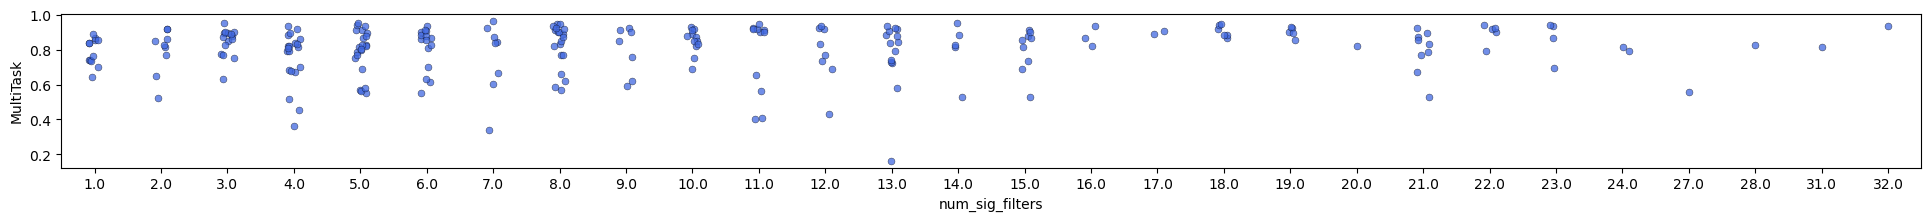

In [28]:
# Plot this relationship and output a correlation
fig, ax = plt.subplots(figsize=(5, 2))
sns.stripplot(data=df, x="num_sig_filters", y="MultiTask", color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
plt.savefig(os.path.join(settings.figure_dir, "num_sig_filters_vs_MT_intensity.pdf"), dpi=300)
spearmanr(df["MultiTask"], df["num_sig_filters"])

In [30]:
# Generate a merged TomTom results df for the supplement
merged_df = pd.DataFrame()
for file in sorted(glob.glob(os.path.join(eu.settings.output_dir, "*0.75*_tomtom.tsv"))):
    name = file.split("/")[-1].split("_")[0]
    if name == "filters":
        name = "multitask"
    x["model"] = name
    x = pd.read_csv(file, comment="#", sep="\t")
    merged_df = pd.concat([merged_df, x])
merged_df.to_csv(os.path.join(eu.settings.output_dir, "all_0.75_tomtom.tsv"), index=False, sep="\t")

# Filter viz

In [34]:
# Load in the PFMs in a SeqData
sdata_test = sd.open_zarr(os.path.join(settings.output_dir, "norm_test_predictions_and_intepretations_0.75.zarr"))

In [35]:
sdata_test

<xarray.Dataset>
Dimensions:                                        (_sequence: 121031, _ohe: 4,
                                                    length: 41,
                                                    _arch.conv1d_tower.layers.1_1024_filters: 1024,
                                                    _arch.conv1d_tower.layers.1_16_kernel_size: 16,
                                                    _arch.conv1d_tower.layers.1_None_filters: 16,
                                                    _arch.conv1d_tower.layers.1_16: 16)
Coordinates:
  * _sequence                                      (_sequence) object 'RBD_v3...
Dimensions without coordinates: _ohe, length,
                                _arch.conv1d_tower.layers.1_1024_filters,
                                _arch.conv1d_tower.layers.1_16_kernel_size,
                                _arch.conv1d_tower.layers.1_None_filters,
                                _arch.conv1d_tower.layers.1_16
Data variables: (12/269)
    InputXGradient_attrs_RNCMPT00023_MT            (_sequence, _ohe, length) float32 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>
    InputXGradient_attrs_RNCMPT00023_ST            (_sequence, _ohe, length) float32 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>
    InputXGradient_attrs_RNCMPT00205_MT            (_sequence, _ohe, length) float32 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>
    InputXGradient_attrs_RNCMPT00205_ST            (_sequence, _ohe, length) float32 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>
    InputXGradient_attrs_RNCMPT00215_MT            (_sequence, _ohe, length) float32 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>
    InputXGradient_attrs_RNCMPT00215_ST            (_sequence, _ohe, length) float32 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>
    ...                                             ...
    arch.conv1d_tower.layers.1_pfmsRNCMPT00215_ST  (_arch.conv1d_tower.layers.1_None_filters, _arch.conv1d_tower.layers.1_16, _ohe) float32 dask.array<chunksize=(16, 16, 4), meta=np.ndarray>
    arch.conv1d_tower.layers.1_pfmsRNCMPT00238_ST  (_arch.conv1d_tower.layers.1_None_filters, _arch.conv1d_tower.layers.1_16, _ohe) float32 dask.array<chunksize=(16, 16, 4), meta=np.ndarray>
    arch.conv1d_tower.layers.1_pfmsRNCMPT00246_ST  (_arch.conv1d_tower.layers.1_None_filters, _arch.conv1d_tower.layers.1_16, _ohe) float32 dask.array<chunksize=(16, 16, 4), meta=np.ndarray>
    arch.conv1d_tower.layers.1_pfmsRNCMPT00268_ST  (_arch.conv1d_tower.layers.1_None_filters, _arch.conv1d_tower.layers.1_16, _ohe) float32 dask.array<chunksize=(16, 16, 4), meta=np.ndarray>
    arch.conv1d_tower.layers.1_pfmsRNCMPT00269_ST  (_arch.conv1d_tower.layers.1_None_filters, _arch.conv1d_tower.layers.1_16, _ohe) float32 dask.array<chunksize=(16, 16, 4), meta=np.ndarray>
    ohe_seq                                        (_sequence, _ohe, length) float16 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>

In [40]:
pl.multifilter_viz?

Signature:
pl.multifilter_viz(
    sdata,
    filter_nums: list,
    pfms_key: str,
    num_rows: int = None,
    num_cols: int = None,
    titles: list = None,
    figsize=(12, 10),
    save: os.PathLike = None,
    **kwargs,
)
Docstring:
Plot multiple filters in a SeqData object's uns dictionary as PWM logos.

This function wraps filter_viz. Getting the figure to look nice it more of an art
than a science. In experimenting so far, I've found that a 8x4 grid with a (12, 10)
figure size works well. 

Parameters 
----------
sdata : SeqData
    The SeqData object with sequences and pfms to plot a logo for
filter_nums : list
    The filter ids to plot
num_rows : int
    The number of rows to use for the figure
num_cols : int
    The number of columns to use for the figure
uns_key : str
    The key in the sdata.uns dictionary that contains the pfms to plot
titles : list
    The titles to use for the plots, defaults to the filter ids if None
figsize : tuple
    The figure size to use for th

IndexError: range object index out of range

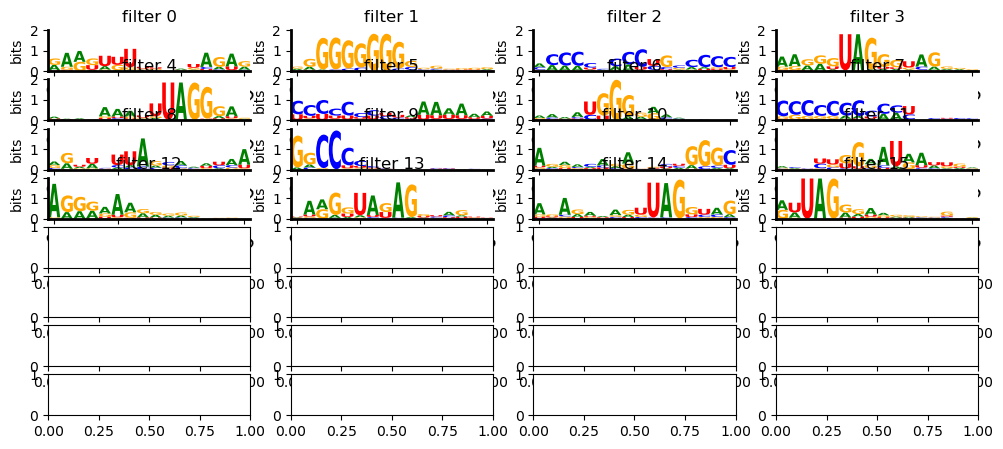

In [41]:
pl.multifilter_viz(
    sdata_test,
    filter_nums=range(0,16),
    pfms_key=f"arch.conv1d_tower.layers.1_pfms{rbp}_ST",
    titles=[f"filter {i}" for i in range(16)],
    vocab="RNA",
    num_rows=8,
    num_cols=4,
    figsize=(12, 5),
    save=os.path.join(eu.settings.figure_dir, "filter_viz", f"filters_viz_{rbp}_0.75_ST_long.pdf")
)

# DONE!

---

# Scratch